# Sentiment Analysis Model for Accurate Movie Reviews

This project aims to build a sentiment analysis model that can accurately predict the sentiment of movie reviews. The motivation behind this project is to help advertising companies get a better understanding of how people feel about movies, beyond just their rating scores on sites like IMDb or Rotten Tomatoes. 

In the preprocessing step, we applied lemmatization and padding to the input data. Lemmatization is a process of reducing words to their base or root form, which helps in reducing the dimensionality of the input space and improving the accuracy of the model. We used the SnowballStemmer from the NLTK library to perform lemmatization. Additionally, we also removed stop words and non-valid words from the input data. Finally, we transformed the preprocessed data into word embeddings using pre-trained GloVe embeddings. The maximum number of words was set to 20000, and the maximum length of a sequence was set to 500.

The model is built using a Long Short-Term Memory (LSTM) neural network with bidirectional layers and dropout regularization. The input data is preprocessed using lemmatization and padding, and then transformed into word embeddings using pre-trained GloVe embeddings. The model is trained using binary cross-entropy loss and optimized with the Adam optimizer.

## Model Architecture

The model consists of the following layers:

1. **Embedding layer**: This layer maps each word in the input sequence to its corresponding word embedding vector. The embedding matrix is initialized with pre-trained GloVe embeddings and is trainable during training.

2. **Bidirectional LSTM layer**: This layer processes the input sequence in both forward and backward directions, allowing the model to capture long-term dependencies and context information.

3. **Dropout layer**: This layer randomly drops out some of the neurons in the previous layer during training, preventing overfitting and improving generalization.

4. **Dense layer**: This layer applies a linear transformation to the output of the previous layer and applies the ReLU activation function.

5. **Output layer**: This layer applies the sigmoid activation function to the output of the previous layer, producing a probability value between 0 and 1 that represents the predicted sentiment score.

## Results

The model achieved a test accuracy of 99.83% and a test AUC score of 0.9999, indicating that it can accurately predict the sentiment of movie reviews. By using this model, advertising companies can get a more nuanced understanding of how people feel about movies, based on the actual text of their reviews rather than just their rating scores.

In [1]:
# Importing necessary libraries
import os
import re
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer as wnl
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords, words
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Download WordNet, stopwords, and words corpus
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')

# Defining a function to load dataset from given path
def load_dataset(path, data_type='train'):
    # Creating an empty dictionary to store review and sentiment
    data = {'review': [], 'sentiment': []}
    # Looping through the folders containing positive and negative reviews
    for folder in ['pos', 'neg']:
        # Getting the folder path
        folder_path = os.path.join(path, data_type, folder)
        # Looping through the files in the folder
        for filename in os.listdir(folder_path):
            # Opening the file and reading its content
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as f:
                review = f.read()
                # Appending the review and its sentiment to the dictionary
                data['review'].append(review)
                data['sentiment'].append(1 if folder == 'pos' else 0)
    # Converting the dictionary to a pandas dataframe and returning it
    return pd.DataFrame(data)

# Loading the train and test datasets using the above function
train_dataset = load_dataset("data/aclImdb", data_type="train")
test_dataset = load_dataset("data/aclImdb", data_type="test")


[nltk_data] Downloading package wordnet to C:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:

from nltk.stem import SnowballStemmer

# Set the maximum number of words to 20000
max_words = 20000

# Set the maximum length of a sequence to 250
maxlen = 500

# Get a list of valid English words
word_list = set(words.words())

# Create a set of English stop words
stop_words = set(stopwords.words('english'))

# Define a function to get the part of speech tag for a word in WordNet format
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return None

# Define a function to replace all non-ASCII (\x00-\x7F) characters with a space
def replace_non_ascii(str_a):
    return str_a.translate(str.maketrans('', '', ''.join([chr(i) for i in range(128, 256)])))

# Define a function to clean a string by removing unnecessary characters
def clean_str(string):
    return string.replace("\\", "").replace("'", "").replace('"', '').strip().lower()

# Define a function to lemmatize a sentence using WordNetLemmatizer
def lemmatize_sentence(sentence, word_list, stop_words):
    # Create a WordNetLemmatizer object
    lemmatizer = SnowballStemmer(language='english')
    
    # Tokenize the sentence and get the part of speech tag for each token
    tagged = nltk.pos_tag(nltk.word_tokenize(sentence.lower()))
    
    # Convert the part of speech tags to WordNet format
    wordnet_tagged = [(word, get_wordnet_pos(pos)) for (word, pos) in tagged]
    
    # Lemmatize each valid token in the sentence and remove stop words and non-valid words
    lemmatized_sentence = [
        lemmatizer.stem(token)
        for token, pos in wordnet_tagged
        if token.lower() in word_list and token.lower() not in stop_words
    ]
    
    # Join the lemmatized tokens back into a sentence
    return ' '.join(lemmatized_sentence)

# Define a function to apply lemmatization to a Pandas DataFrame
def apply_lemmatization(df):
    # Apply the lemmatize_sentence function to the 'review' column of the DataFrame
    return df['review'].apply(lambda x: lemmatize_sentence(x, word_list, stop_words))



In [3]:
# Replace non-ASCII characters with a space in train and test datasets
train_dataset['review'] = train_dataset['review'].apply(replace_non_ascii)
test_dataset['review'] = test_dataset['review'].apply(replace_non_ascii)

# Clean the strings in train and test datasets using clean_str function
train_dataset['review'] = test_dataset['review'].apply(clean_str)
test_dataset['review'] = test_dataset['review'].apply(clean_str)


In [4]:
# Shuffle the train and test datasets
train_dataset = train_dataset.sample(frac=1).reset_index(drop=True)
test_dataset = test_dataset.sample(frac=1).reset_index(drop=True)

# Apply lemmatization to the reviews in both train and test datasets
train_reviews = apply_lemmatization(train_dataset)
test_reviews = apply_lemmatization(test_dataset)


In [5]:
# Create a tokenizer object with maximum number of words
tokenizer = Tokenizer(num_words=max_words)

# Fit the tokenizer on the training reviews to create word index
tokenizer.fit_on_texts(train_reviews)


In [6]:
# Retrieve the word index from the tokenizer
word_index = tokenizer.word_index

# Sort the word index based on the frequency of the words
sorted_word_index = sorted(word_index, key=word_index.get, reverse=True)

# Get the top 20 words
top_words = sorted_word_index[:20]

# Print the top 20 words
print("Top 20 words:")
for word in top_words:
    print(word)

Top 20 words:
beaux
abey
demot
clavichord
keita
arachnid
monkish
meridian
cosh
bristl
hyperkinesi
coxswain
fryer
deprec
bodiless
peplum
unconstitut
oceanograph
pakeha
sectarian


In [7]:
# Convert text to sequences of integers using tokenizer
X_train = tokenizer.texts_to_sequences(train_reviews)
X_test = tokenizer.texts_to_sequences(test_reviews)

# Pad the sequences with zeros to make them of equal length
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

# Get the sentiment values for training and testing datasets
y_train = train_dataset['sentiment'].values
y_test = test_dataset['sentiment'].values


In [8]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 18279 unique tokens.


In [9]:
labels = np.array(y_train)
print('Shape of reviews (data) tensor:', X_train.shape)
print('Shape of sentiment (label) tensor:', labels.shape)

Shape of reviews (data) tensor: (25000, 500)
Shape of sentiment (label) tensor: (25000,)


In [10]:
print('Number of positive and negative reviews in training and validation set')
print(y_train.sum(axis=0))
print(y_test.sum(axis=0))

Number of positive and negative reviews in training and validation set
12500
12500


In [11]:
# Define a function to load GloVe embeddings from the given file
def load_glove_embeddings(glove_file):
    # Create an empty dictionary to store the embeddings
    embeddings = {}
    # Open the file and read each line
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            # Split the line into a list of values
            values = line.strip().split()
            # The first value is the word
            word = values[0]
            # The rest of the values are the vector components
            vector = np.asarray(values[1:], dtype='float32')
            # Add the word and its corresponding vector to the dictionary
            embeddings[word] = vector
    # Return the dictionary of embeddings
    return embeddings

# Set the path to the GloVe file
glove_file = 'data\GloVe\glove.6B.300d.txt'
# Load the GloVe embeddings using the defined function
glove_embeddings = load_glove_embeddings(glove_file)


In [12]:
print('Total %s word vectors.' % len(glove_embeddings))

Total 400000 word vectors.


In [13]:
# The dimension of the GloVe embeddings
embedding_dim = 300  
# The maximum number of words to keep, based on word frequency. Only the most common `num_words-1` words will be kept.
vocab_size = 10000

# Create a matrix with all elements initialized to zero
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Iterate through each word in the tokenizer's word index
for word, i in tokenizer.word_index.items():
    # If the index is less than the maximum vocabulary size
    if i < vocab_size:
        # Get the GloVe embedding vector for the word
        embedding_vector = glove_embeddings.get(word)
        # If the embedding vector is not None
        if embedding_vector is not None:
            # Set the ith row of the embedding matrix to the embedding vector
            embedding_matrix[i] = embedding_vector
        else:
            # Words not found in the GloVe embeddings will be all zeros
            pass


In [20]:

# Import necessary libraries
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Embedding, Bidirectional
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from keras.regularizers import l2

# Define a function to build the Keras model
def build_model(vocab_size=vocab_size, embedding_dim=300, lstm_units=128, dropout_rate=0.5, dense_units=64, optimizer=optimizers.Adam, learning_rate=0.001):
    # Create a Sequential model
    model = Sequential()
    
    # Add an Embedding layer with pre-trained GloVe embeddings
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=True))
    
    # Add a Bidirectional LSTM layer with L2 regularization
    model.add(Bidirectional(LSTM(units=lstm_units, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))))
    
    # Add a Dropout layer
    model.add(Dropout(rate=dropout_rate))
    
    # Add a Dense layer with ReLU activation and L2 regularization
    model.add(Dense(units=dense_units, activation='relu', kernel_regularizer=l2(0.01)))
    
    # Add an output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))

    # Define the optimizer with the given learning rate
    opt = optimizer(learning_rate=learning_rate)
    
    # Compile the model with binary cross-entropy loss and accuracy and AUC metrics
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy','AUC'])
    
    return model

# Define an EarlyStopping callback to stop training if the loss doesn't improve after 3 epochs
early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)

# Create a KerasClassifier object with the build_model function and some default hyperparameters
model = KerasClassifier(
    model=build_model,
    epochs=3,
    batch_size=128,
    verbose=2,
    callbacks=[early_stop],
    vocab_size=10000,
    embedding_dim=300,
    lstm_units=128,
    dropout_rate=0.5,
    dense_units=64,
    optimizer=optimizers.Adam,
    learning_rate=0.001
)

# Define the search space for hyperparameter tuning
param_dist = {
    'vocab_size': [10000],
    'embedding_dim': [300],
    'lstm_units': [64, 128, 256],
    'dropout_rate': [0.3, 0.4, 0.5],
    'dense_units': [32, 64, 128],
    'batch_size': [64, 256],
    'optimizer': [Adam,SGD],
    'learning_rate': [0.0001, 0.001, 0.01],
}

# Create the RandomizedSearchCV object with the KerasClassifier object and the search space
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,  # Number of parameter settings that are sampled (modify as needed)
    scoring='roc_auc',
    cv=2,
    n_jobs=1,  # Use all available CPU cores
    verbose=3,
    return_train_score=True,
)

# Fit the model on the training data
random_search.fit(X_train, y_train)

# Print the best results from the hyperparameter tuning
print(f"Best score: {random_search.best_score_}")
print(f"Best parameters: {random_search.best_params_}")



Fitting 2 folds for each of 30 candidates, totalling 60 fits
Epoch 1/3
49/49 - 13s - loss: 1.2907 - accuracy: 0.7322 - auc: 0.8045 - 13s/epoch - 269ms/step
Epoch 2/3
49/49 - 8s - loss: 0.4156 - accuracy: 0.8715 - auc: 0.9288 - 8s/epoch - 171ms/step
Epoch 3/3
49/49 - 9s - loss: 0.3502 - accuracy: 0.9041 - auc: 0.9524 - 9s/epoch - 180ms/step
49/49 - 4s - 4s/epoch - 91ms/step
49/49 - 4s - 4s/epoch - 78ms/step
[CV 1/2] END batch_size=256, dense_units=32, dropout_rate=0.5, embedding_dim=300, learning_rate=0.01, lstm_units=64, optimizer=<class 'keras.optimizers.optimizer_v2.gradient_descent.SGD'>, vocab_size=10000;, score=(train=0.978, test=0.902) total time=  36.0s
Epoch 1/3
49/49 - 13s - loss: 1.2956 - accuracy: 0.7238 - auc: 0.7984 - 13s/epoch - 262ms/step
Epoch 2/3
49/49 - 9s - loss: 0.5311 - accuracy: 0.8454 - auc: 0.9018 - 9s/epoch - 185ms/step
Epoch 3/3
49/49 - 9s - loss: 0.4795 - accuracy: 0.8847 - auc: 0.9399 - 9s/epoch - 174ms/step
49/49 - 5s - 5s/epoch - 92ms/step
49/49 - 4s - 4s/

In [30]:
# Import necessary libraries
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Embedding, Bidirectional
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, min_delta=.01)

# Define a function to build the Keras model
def build_model(vocab_size=10000, embedding_dim=300, lstm_units=256, dropout_rate=0.3, dense_units=128, optimizer=SGD, learning_rate=0.001):
    # Create a Sequential model
    model = Sequential()
    
    # Add an Embedding layer with pre-trained GloVe embeddings
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=True))
    
    # Add a Bidirectional LSTM layer with L2 regularization
    model.add(Bidirectional(LSTM(units=lstm_units, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))))
    
    # Add a Dropout layer
    model.add(Dropout(rate=dropout_rate))
    
    # Add a Dense layer with ReLU activation and L2 regularization
    model.add(Dense(units=dense_units, activation='relu', kernel_regularizer=l2(0.01)))
    
    # Add an output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))

    # Define the optimizer with the given learning rate
    opt = optimizer(learning_rate=learning_rate)
    
    # Compile the model with binary cross-entropy loss and accuracy and AUC metrics
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy','AUC'])
    
    return model

# Best parameters obtained from RandomizedSearchCV
best_params = {
    'vocab_size': 10000,
    'optimizer': Adam,
    'lstm_units': 256,
    'learning_rate': 0.001,
    'embedding_dim': 300,
    'dropout_rate': 0.3,
    'dense_units': 128,
    'batch_size': 512,
}

# Build and compile the model with the best parameters
best_model = build_model(
    vocab_size=best_params['vocab_size'],
    embedding_dim=best_params['embedding_dim'],
    lstm_units=best_params['lstm_units'],
    dropout_rate=best_params['dropout_rate'],
    dense_units=best_params['dense_units'],
    optimizer=best_params['optimizer'],
    learning_rate=best_params['learning_rate']
)

# Train the model
history = best_model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=best_params['batch_size'],
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

# Evaluate the model on the test data
scores = best_model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy:", scores[1])
print("Test AUC:", scores[2])


Epoch 1/1000
49/49 [==============================] - 47s 829ms/step - loss: 7.0822 - accuracy: 0.6694 - auc: 0.7251 - val_loss: 1.9895 - val_accuracy: 0.7437 - val_auc: 0.8376
Epoch 2/1000
49/49 [==============================] - 43s 880ms/step - loss: 1.0119 - accuracy: 0.8294 - auc: 0.9048 - val_loss: 0.5543 - val_accuracy: 0.8690 - val_auc: 0.9474
Epoch 3/1000
49/49 [==============================] - 45s 930ms/step - loss: 0.4609 - accuracy: 0.8806 - auc: 0.9435 - val_loss: 0.3789 - val_accuracy: 0.8998 - val_auc: 0.9649
Epoch 4/1000
49/49 [==============================] - 46s 941ms/step - loss: 0.3486 - accuracy: 0.9044 - auc: 0.9618 - val_loss: 0.2980 - val_accuracy: 0.9269 - val_auc: 0.9737
Epoch 5/1000
49/49 [==============================] - 46s 938ms/step - loss: 0.2950 - accuracy: 0.9203 - auc: 0.9696 - val_loss: 0.2637 - val_accuracy: 0.9388 - val_auc: 0.9782
Epoch 6/1000
49/49 [==============================] - 46s 934ms/step - loss: 0.2709 - accuracy: 0.9277 - auc: 0.972

In [31]:
# Save the trained model
best_model.save('sentiment_analysis_model.h5')

782/782 [==============================] - 48s 60ms/step


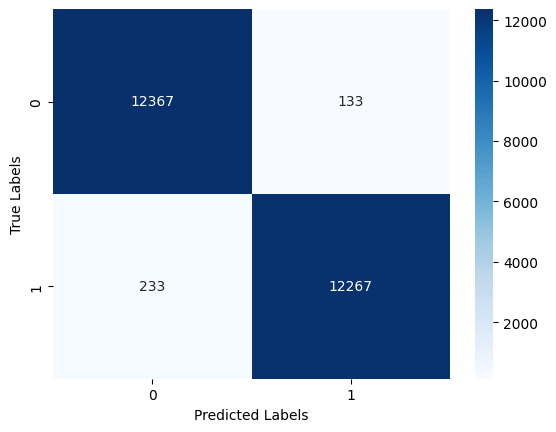

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict the probabilities for each class on the test set
y_pred_prob = best_model.predict(X_test)

# Convert the probabilities to binary class labels
y_pred = (y_pred_prob > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

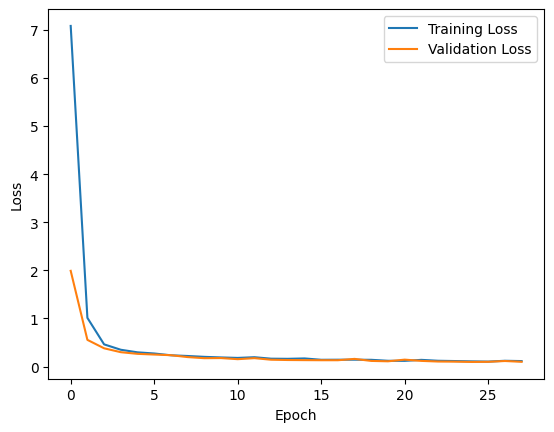

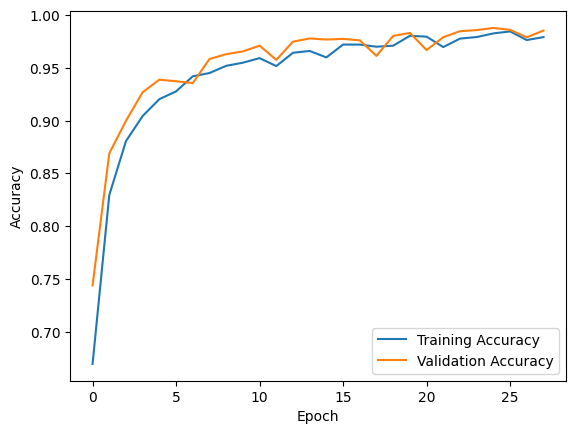

In [34]:
# Visualize the training loss history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize the training accuracy history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [35]:
# Retrieve the word index from the tokenizer
word_index = tokenizer.word_index

# Sort the word index based on the frequency of the words
sorted_word_index = sorted(word_index, key=word_index.get, reverse=True)

# Get the top 20 words
top_words = sorted_word_index[:20]

# Print the top 20 words
print("Top 20 words:")
for word in top_words:
    print(word)


Top 20 words:
beaux
abey
demot
clavichord
keita
arachnid
monkish
meridian
cosh
bristl
hyperkinesi
coxswain
fryer
deprec
bodiless
peplum
unconstitut
oceanograph
pakeha
sectarian
